In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
sys.path.append(os.path.abspath(os.path.join('..')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

import src.modelling_pipeline as modelling_pipeline
reload(modelling_pipeline)

mp = modelling_pipeline.ModelPipeline(ROOT_DIR)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask


In [7]:
def data_preparation():
  train_data, act_train, mask_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test, mask_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [8]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [11]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = LSTM_model()
models.append(model)

In [13]:
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [14]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = GRU_model()
models.append(model)

In [15]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [16]:
from sklearn.model_selection import StratifiedKFold
k = 5
num_epochs = 40

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")
  
  checkpointer = ModelCheckpoint(filepath = f'weights_best_struct_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  callbacks_list = [lr_scheduler, early_stop, checkpointer]
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)
  
  # Loop through the k folds
  for j, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(1))):
    print(f'---------------------Start K={j}-------------------------------')
    
    x_train_kf, x_val_kf = tf.gather(x_train, train_index), tf.gather(x_train, val_index)
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    sample_weights = me.compute_sample_weights(y_train_kf[:,1].astype(int))

    # Train the model
    m = model.fit(x_train_kf,y_train_kf,
              sample_weight=sample_weights,
              epochs=num_epochs, batch_size=64, verbose=1,
              validation_data=(x_val_kf, y_val_kf),
              callbacks=callbacks_list)
    m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               88064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 88322 (345.01 KB)
Trainable params: 88322 (345.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------Start K=0-------------------------------
Epoch 1/40
463/463 [==============================] - 6s 9ms/step - loss: 0.5679 - accuracy: 0.6947 - auc: 0.7521 - val_loss: 0.5157 - val_accuracy: 0.7700 - val_auc: 0.

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 4s 9ms/step - loss: 0.5141 - accuracy: 0.7601 - auc: 0.8225 - val_loss: 0.4782 - val_accuracy: 0.7942 - val_auc: 0.8564 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4979 - accuracy: 0.7697 - auc: 0.8356 - val_loss: 0.4787 - val_accuracy: 0.7878 - val_auc: 0.8553 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4837 - accuracy: 0.7750 - auc: 0.8456 - val_loss: 0.5173 - val_accuracy: 0.7644 - val_auc: 0.8285 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4704 - accuracy: 0.7817 - auc: 0.8524 - val_loss: 0.5030 - val_accuracy: 0.7727 - val_auc: 0.8395 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4642 - accuracy: 0.7853 - auc: 0.8591 - val_loss: 0.5106 - val_accuracy: 0.7667 - val_auc: 0.8336 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.4728 - accuracy: 0.7866 - auc: 0.8553 - val_loss: 0.4914 - val_accuracy: 0.7743 - val_auc: 0.8423 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4641 - accuracy: 0.7860 - auc: 0.8554 - val_loss: 0.4635 - val_accuracy: 0.7889 - val_auc: 0.8621 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4554 - accuracy: 0.7903 - auc: 0.8646 - val_loss: 0.4805 - val_accuracy: 0.7827 - val_auc: 0.8512 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4434 - accuracy: 0.7980 - auc: 0.8710 - val_loss: 0.4469 - val_accuracy: 0.8009 - val_auc: 0.8729 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4348 - accuracy: 0.8016 - auc: 0.8762 - val_loss: 0.4688 - val_accuracy: 0.7915 - val_auc: 0.8607 - lr: 4.9659e-04
---------------------Start K=2---------------------

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.4464 - accuracy: 0.7961 - auc: 0.8684 - val_loss: 0.4780 - val_accuracy: 0.7766 - val_auc: 0.8508 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4341 - accuracy: 0.8006 - auc: 0.8744 - val_loss: 0.4442 - val_accuracy: 0.7950 - val_auc: 0.8723 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4234 - accuracy: 0.8051 - auc: 0.8819 - val_loss: 0.4413 - val_accuracy: 0.7952 - val_auc: 0.8752 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4139 - accuracy: 0.8134 - auc: 0.8885 - val_loss: 0.4448 - val_accuracy: 0.7985 - val_auc: 0.8742 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4027 - accuracy: 0.8155 - auc: 0.8914 - val_loss: 0.4214 - val_accuracy: 0.8153 - val_auc: 0.8889 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 14ms/step - loss: 0.4015 - accuracy: 0.8239 - auc: 0.8980 - val_loss: 0.4015 - val_accuracy: 0.8171 - val_auc: 0.8967 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 7s 14ms/step - loss: 0.3897 - accuracy: 0.8249 - auc: 0.9007 - val_loss: 0.3606 - val_accuracy: 0.8400 - val_auc: 0.9175 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3750 - accuracy: 0.8364 - auc: 0.9097 - val_loss: 0.3840 - val_accuracy: 0.8300 - val_auc: 0.9058 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3660 - accuracy: 0.8356 - auc: 0.9109 - val_loss: 0.3763 - val_accuracy: 0.8351 - val_auc: 0.9101 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 7s 15ms/step - loss: 0.3587 - accuracy: 0.8407 - auc: 0.9155 - val_loss: 0.3692 - val_accuracy: 0.8366 - val_auc: 0.9146 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3646 - accuracy: 0.8359 - auc: 0.9129 - val_loss: 0.3462 - val_accuracy: 0.8470 - val_auc: 0.9239 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3709 - accuracy: 0.8334 - auc: 0.9108 - val_loss: 0.3964 - val_accuracy: 0.8222 - val_auc: 0.9001 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3495 - accuracy: 0.8440 - auc: 0.9193 - val_loss: 0.3532 - val_accuracy: 0.8441 - val_auc: 0.9211 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3376 - accuracy: 0.8510 - auc: 0.9244 - val_loss: 0.3504 - val_accuracy: 0.8496 - val_auc: 0.9245 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3273 - accuracy: 0.8558 - auc: 0.9292 - val_loss: 0.3662 - val_accuracy: 0.8453 - val_auc: 0.9197 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.5151 - accuracy: 0.7652 - auc: 0.8223 - val_loss: 0.5529 - val_accuracy: 0.7393 - val_auc: 0.7978 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4977 - accuracy: 0.7676 - auc: 0.8326 - val_loss: 0.5315 - val_accuracy: 0.7553 - val_auc: 0.8163 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4834 - accuracy: 0.7752 - auc: 0.8437 - val_loss: 0.5000 - val_accuracy: 0.7736 - val_auc: 0.8422 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4747 - accuracy: 0.7820 - auc: 0.8524 - val_loss: 0.4896 - val_accuracy: 0.7831 - val_auc: 0.8531 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4593 - accuracy: 0.7865 - auc: 0.8618 - val_loss: 0.5236 - val_accuracy: 0.7678 - val_auc: 0.8336 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.4209 - accuracy: 0.8126 - auc: 0.8860 - val_loss: 0.4424 - val_accuracy: 0.8029 - val_auc: 0.8749 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4138 - accuracy: 0.8149 - auc: 0.8897 - val_loss: 0.4312 - val_accuracy: 0.8158 - val_auc: 0.8857 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4001 - accuracy: 0.8226 - auc: 0.8969 - val_loss: 0.3928 - val_accuracy: 0.8269 - val_auc: 0.9035 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3897 - accuracy: 0.8240 - auc: 0.9002 - val_loss: 0.4173 - val_accuracy: 0.8155 - val_auc: 0.8923 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3865 - accuracy: 0.8302 - auc: 0.9064 - val_loss: 0.4034 - val_accuracy: 0.8278 - val_auc: 0.9006 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3788 - accuracy: 0.8375 - auc: 0.9126 - val_loss: 0.3525 - val_accuracy: 0.8518 - val_auc: 0.9258 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3601 - accuracy: 0.8400 - auc: 0.9163 - val_loss: 0.3728 - val_accuracy: 0.8419 - val_auc: 0.9162 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3487 - accuracy: 0.8483 - auc: 0.9235 - val_loss: 0.3670 - val_accuracy: 0.8438 - val_auc: 0.9173 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3388 - accuracy: 0.8496 - auc: 0.9268 - val_loss: 0.3572 - val_accuracy: 0.8499 - val_auc: 0.9231 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3307 - accuracy: 0.8565 - auc: 0.9311 - val_loss: 0.3521 - val_accuracy: 0.8517 - val_auc: 0.9253 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 12ms/step - loss: 0.3364 - accuracy: 0.8532 - auc: 0.9287 - val_loss: 0.3474 - val_accuracy: 0.8518 - val_auc: 0.9263 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 12ms/step - loss: 0.3269 - accuracy: 0.8576 - auc: 0.9320 - val_loss: 0.3705 - val_accuracy: 0.8447 - val_auc: 0.9192 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3213 - accuracy: 0.8629 - auc: 0.9354 - val_loss: 0.3597 - val_accuracy: 0.8485 - val_auc: 0.9224 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3101 - accuracy: 0.8665 - auc: 0.9392 - val_loss: 0.3440 - val_accuracy: 0.8570 - val_auc: 0.9289 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3019 - accuracy: 0.8735 - auc: 0.9433 - val_loss: 0.3779 - val_accuracy: 0.8465 - val_auc: 0.9186 - lr: 4.4933e-04
---------------------Start K=4---------------------

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3147 - accuracy: 0.8631 - auc: 0.9372 - val_loss: 0.3006 - val_accuracy: 0.8733 - val_auc: 0.9450 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3089 - accuracy: 0.8681 - auc: 0.9398 - val_loss: 0.3246 - val_accuracy: 0.8690 - val_auc: 0.9369 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2983 - accuracy: 0.8711 - auc: 0.9444 - val_loss: 0.3272 - val_accuracy: 0.8645 - val_auc: 0.9357 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2912 - accuracy: 0.8748 - auc: 0.9465 - val_loss: 0.3360 - val_accuracy: 0.8637 - val_auc: 0.9333 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2839 - accuracy: 0.8786 - auc: 0.9489 - val_loss: 0.3341 - val_accuracy: 0.8679 - val_auc: 0.9346 - lr: 4.4933e-04
----------------Start model 2---------------------


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.5118 - accuracy: 0.7640 - auc: 0.8275 - val_loss: 0.5325 - val_accuracy: 0.7447 - val_auc: 0.8122 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4980 - accuracy: 0.7665 - auc: 0.8361 - val_loss: 0.4944 - val_accuracy: 0.7750 - val_auc: 0.8432 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4866 - accuracy: 0.7724 - auc: 0.8435 - val_loss: 0.4976 - val_accuracy: 0.7735 - val_auc: 0.8415 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4741 - accuracy: 0.7796 - auc: 0.8537 - val_loss: 0.4987 - val_accuracy: 0.7611 - val_auc: 0.8364 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4623 - accuracy: 0.7855 - auc: 0.8604 - val_loss: 0.5084 - val_accuracy: 0.7584 - val_auc: 0.8317 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.4202 - accuracy: 0.8122 - auc: 0.8852 - val_loss: 0.4295 - val_accuracy: 0.8034 - val_auc: 0.8814 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4111 - accuracy: 0.8130 - auc: 0.8892 - val_loss: 0.4140 - val_accuracy: 0.8192 - val_auc: 0.8921 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4027 - accuracy: 0.8206 - auc: 0.8957 - val_loss: 0.4533 - val_accuracy: 0.7946 - val_auc: 0.8688 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3911 - accuracy: 0.8253 - auc: 0.9012 - val_loss: 0.4102 - val_accuracy: 0.8173 - val_auc: 0.8938 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3792 - accuracy: 0.8317 - auc: 0.9069 - val_loss: 0.4197 - val_accuracy: 0.8174 - val_auc: 0.8905 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.3768 - accuracy: 0.8308 - auc: 0.9081 - val_loss: 0.3960 - val_accuracy: 0.8249 - val_auc: 0.8998 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3634 - accuracy: 0.8342 - auc: 0.9116 - val_loss: 0.3655 - val_accuracy: 0.8397 - val_auc: 0.9154 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3526 - accuracy: 0.8431 - auc: 0.9178 - val_loss: 0.3819 - val_accuracy: 0.8364 - val_auc: 0.9082 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3485 - accuracy: 0.8459 - auc: 0.9210 - val_loss: 0.3869 - val_accuracy: 0.8334 - val_auc: 0.9081 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3384 - accuracy: 0.8521 - auc: 0.9254 - val_loss: 0.4037 - val_accuracy: 0.8265 - val_auc: 0.8999 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 12ms/step - loss: 0.3638 - accuracy: 0.8359 - auc: 0.9136 - val_loss: 0.3577 - val_accuracy: 0.8443 - val_auc: 0.9191 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 12ms/step - loss: 0.3541 - accuracy: 0.8412 - auc: 0.9168 - val_loss: 0.3501 - val_accuracy: 0.8491 - val_auc: 0.9231 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3481 - accuracy: 0.8441 - auc: 0.9202 - val_loss: 0.3891 - val_accuracy: 0.8357 - val_auc: 0.9046 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3394 - accuracy: 0.8493 - auc: 0.9240 - val_loss: 0.3469 - val_accuracy: 0.8539 - val_auc: 0.9241 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3384 - accuracy: 0.8587 - auc: 0.9309 - val_loss: 0.3905 - val_accuracy: 0.8391 - val_auc: 0.9056 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3421 - accuracy: 0.8499 - auc: 0.9229 - val_loss: 0.3235 - val_accuracy: 0.8569 - val_auc: 0.9349 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3331 - accuracy: 0.8561 - auc: 0.9275 - val_loss: 0.3762 - val_accuracy: 0.8274 - val_auc: 0.9102 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3250 - accuracy: 0.8558 - auc: 0.9307 - val_loss: 0.3201 - val_accuracy: 0.8592 - val_auc: 0.9351 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3107 - accuracy: 0.8634 - auc: 0.9337 - val_loss: 0.2900 - val_accuracy: 0.8790 - val_auc: 0.9464 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3012 - accuracy: 0.8717 - auc: 0.9400 - val_loss: 0.3281 - val_accuracy: 0.8573 - val_auc: 0.9318 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.5126 - accuracy: 0.7580 - auc: 0.8208 - val_loss: 0.4758 - val_accuracy: 0.7873 - val_auc: 0.8576 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4962 - accuracy: 0.7688 - auc: 0.8369 - val_loss: 0.4638 - val_accuracy: 0.7913 - val_auc: 0.8634 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4859 - accuracy: 0.7753 - auc: 0.8461 - val_loss: 0.5275 - val_accuracy: 0.7478 - val_auc: 0.8168 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4784 - accuracy: 0.7739 - auc: 0.8476 - val_loss: 0.4860 - val_accuracy: 0.7736 - val_auc: 0.8477 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4672 - accuracy: 0.7814 - auc: 0.8562 - val_loss: 0.4502 - val_accuracy: 0.7936 - val_auc: 0.8715 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] 

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.4581 - accuracy: 0.7857 - auc: 0.8631 - val_loss: 0.4424 - val_accuracy: 0.8017 - val_auc: 0.8760 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4493 - accuracy: 0.7931 - auc: 0.8681 - val_loss: 0.4313 - val_accuracy: 0.8013 - val_auc: 0.8816 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4385 - accuracy: 0.7965 - auc: 0.8740 - val_loss: 0.4419 - val_accuracy: 0.8037 - val_auc: 0.8764 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4268 - accuracy: 0.8057 - auc: 0.8821 - val_loss: 0.4244 - val_accuracy: 0.8096 - val_auc: 0.8864 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4185 - accuracy: 0.8102 - auc: 0.8872 - val_loss: 0.4624 - val_accuracy: 0.7891 - val_auc: 0.8654 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] -

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.3863 - accuracy: 0.8248 - auc: 0.9043 - val_loss: 0.4024 - val_accuracy: 0.8214 - val_auc: 0.8983 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3704 - accuracy: 0.8316 - auc: 0.9112 - val_loss: 0.3866 - val_accuracy: 0.8313 - val_auc: 0.9075 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3615 - accuracy: 0.8363 - auc: 0.9145 - val_loss: 0.3800 - val_accuracy: 0.8368 - val_auc: 0.9106 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3618 - accuracy: 0.8377 - auc: 0.9167 - val_loss: 0.3932 - val_accuracy: 0.8336 - val_auc: 0.9068 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3508 - accuracy: 0.8453 - auc: 0.9225 - val_loss: 0.4006 - val_accuracy: 0.8335 - val_auc: 0.9033 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.3665 - accuracy: 0.8352 - auc: 0.9151 - val_loss: 0.3586 - val_accuracy: 0.8426 - val_auc: 0.9198 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3533 - accuracy: 0.8417 - auc: 0.9191 - val_loss: 0.3197 - val_accuracy: 0.8606 - val_auc: 0.9367 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3453 - accuracy: 0.8443 - auc: 0.9227 - val_loss: 0.3627 - val_accuracy: 0.8428 - val_auc: 0.9187 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3316 - accuracy: 0.8526 - auc: 0.9300 - val_loss: 0.3433 - val_accuracy: 0.8515 - val_auc: 0.9274 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3267 - accuracy: 0.8582 - auc: 0.9331 - val_loss: 0.3761 - val_accuracy: 0.8358 - val_auc: 0.9139 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.3352 - accuracy: 0.8606 - auc: 0.9359 - val_loss: 0.4114 - val_accuracy: 0.8194 - val_auc: 0.8966 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3169 - accuracy: 0.8599 - auc: 0.9348 - val_loss: 0.3450 - val_accuracy: 0.8530 - val_auc: 0.9274 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3001 - accuracy: 0.8669 - auc: 0.9417 - val_loss: 0.3190 - val_accuracy: 0.8645 - val_auc: 0.9378 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2934 - accuracy: 0.8740 - auc: 0.9451 - val_loss: 0.3297 - val_accuracy: 0.8596 - val_auc: 0.9336 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2916 - accuracy: 0.8706 - auc: 0.9449 - val_loss: 0.3160 - val_accuracy: 0.8667 - val_auc: 0.9396 - lr: 4.4933e-04


In [40]:
reload(me)

chart_types = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
mean_history = me.cal_model_mean(m_hist, k, chart_types)

Mean of empty slice
Degrees of freedom <= 0 for slice.


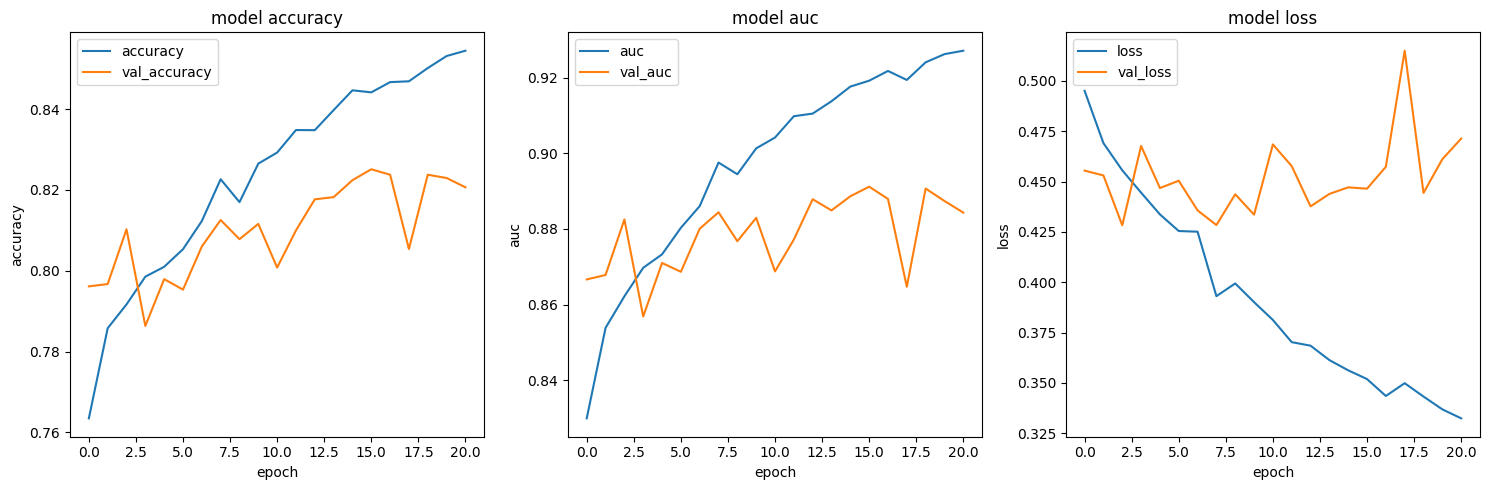

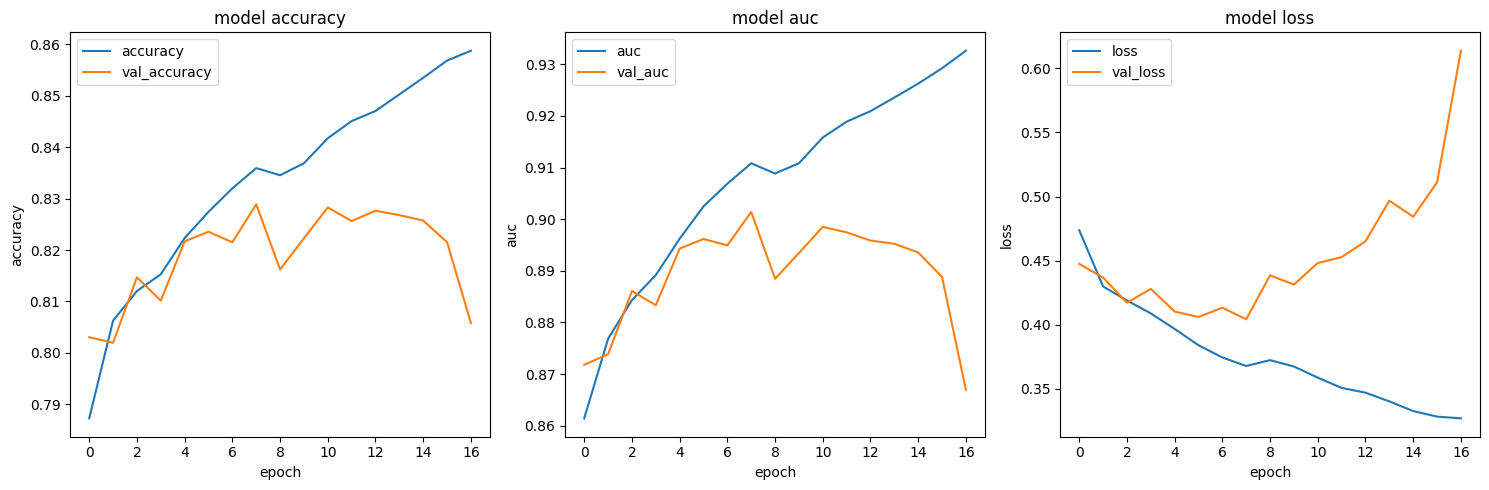

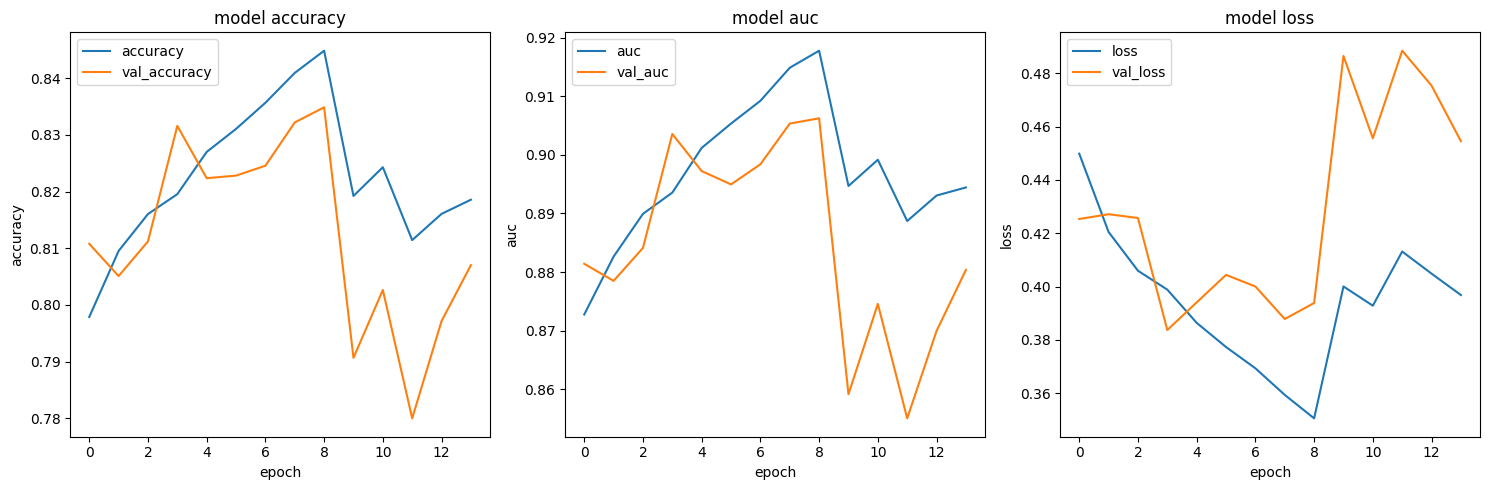

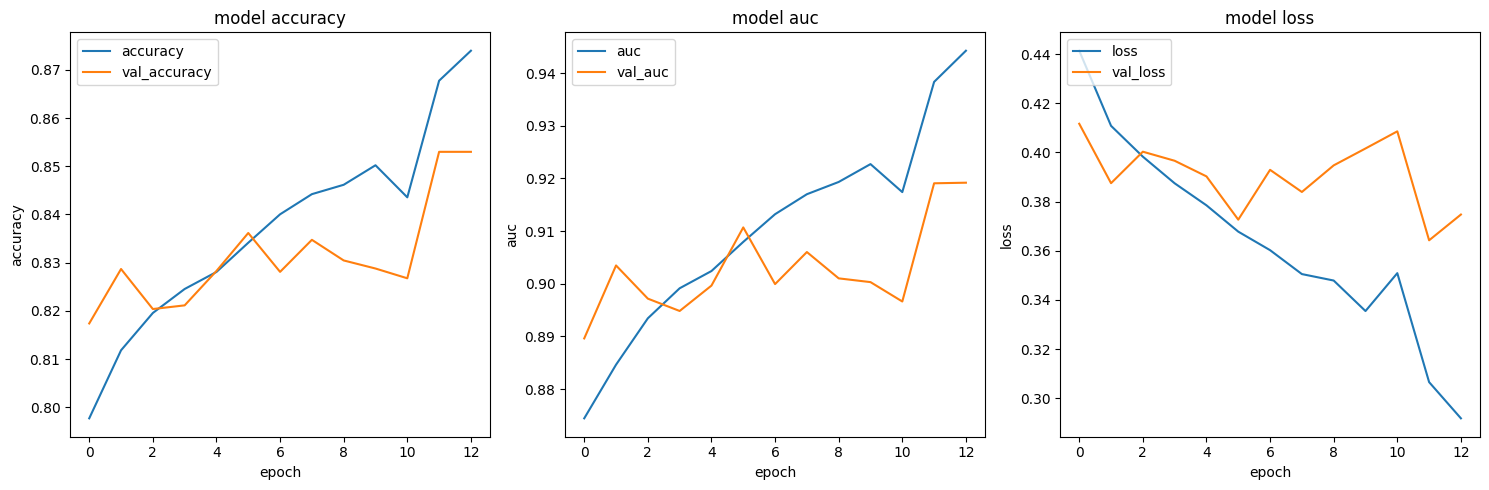

In [41]:
import matplotlib.pyplot as plt

for i, _ in enumerate(mean_history):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(mean_history[i][0])
  plt1.plot(mean_history[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(mean_history[i][2])
  plt2.plot(mean_history[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(mean_history[i][4])
  plt3.plot(mean_history[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

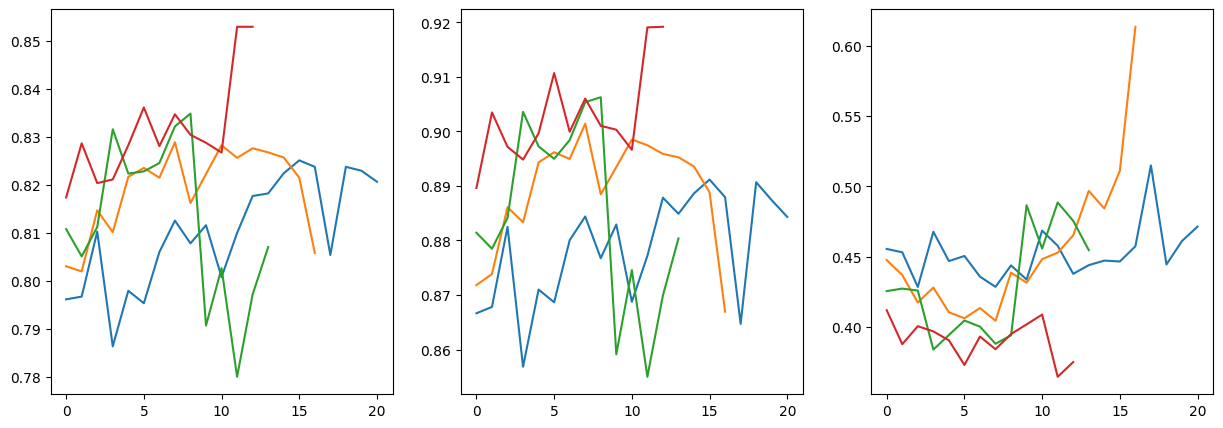

In [42]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(mean_history[0][chart+1])
  plts[i].plot(mean_history[1][chart+1])
  plts[i].plot(mean_history[2][chart+1])
  plts[i].plot(mean_history[3][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
Inference:
289/289 [==============================] - 0s 2ms/step


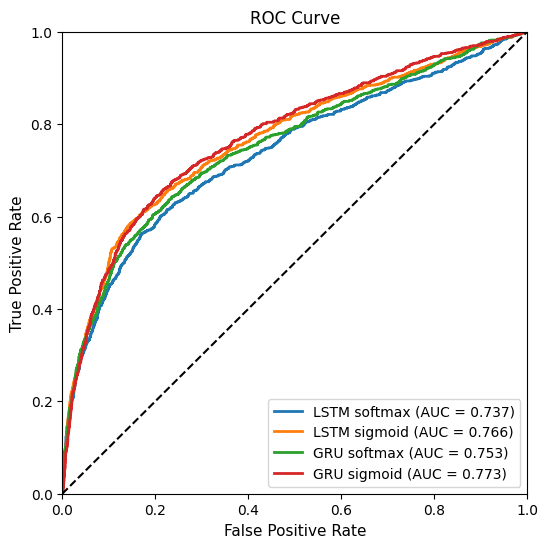

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,LSTM softmax,0.865824,0.685796,0.484897,0.308207,0.839156,0.509548,0.614634,0.384091
1,LSTM sigmoid,0.870439,0.718113,0.476117,0.332174,0.854235,0.575879,0.611441,0.421324
2,GRU softmax,0.873209,0.700758,0.494310,0.323833,0.851470,0.536683,0.625496,0.403933
3,GRU sigmoid,0.865501,0.715352,0.464212,0.318107,0.849208,0.580905,0.600284,0.411095


In [39]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['LSTM softmax', 'LSTM sigmoid', 'GRU softmax', 'GRU sigmoid']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_struct_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)